Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd

In [2]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

doga-MSISSD_khs_dir = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery
doga-MSISSD_data_path = /mnt/USB_HDD_1TB/Datasets
doga-MSISSD_experiment_path = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH


In [4]:
sys.path.insert(1, khs_dir)
import helperFuncs as funcH

In [5]:
EXPERIMENT_ID = 11
LOSS_TYPE='kl'
LOSS_REDUCTION='sum' #'batchmean','mean'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [6]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [7]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 50  # args['epochs']
reg_param = 0.5  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [8]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda:0


In [9]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [10]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        bottleneck = F.relu(self.enc5(x))  
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [11]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [18]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    rho_val = 1/bt.size(1)
    rho_mat = torch.tensor([rho_val] * np.ones(bt.size()), dtype=torch.float32).to(device)
    #https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/13
    #KLDLoss(p, q), sum(q) needs to equal one
    #p = log_softmax(tensor)
    loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    else:
        bt = bottleneck    
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(bt, preds)    
    return loss_ret_1

In [19]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [20]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [21]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [22]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_dgmsissd :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_dgmsissd :: 
EXPERIMENT_ID:  11
LOSS_TYPE :  kl
LOSS_REDUCTION :  sum
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param * sp_loss
*****
 Epoch 0 of 50
TrEpoch(000) - kl tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
sp_loss: 0.002806246280670166

       acc    bmx  bmn      mse   spr      run
0  13.833  0.484  0.0  212.311  2.77  213.696
ValEpoch(000) - 
      acc    bmx  bmn    run
0  23.08  0.263  0.0  27.49
*****
 Epoch 1 of 50
TrEpoch(001) - 
       acc    bmx  bmn      mse    spr     run
0  31.122  0.244  0.0  139.553  1.854  140.48
ValEpoch(001) - 
      acc    bmx  bmn     run
0  34.91  0.189  0.0  20.536
*****
 Epoch 2 of 50
TrEpoch(002) - 
       acc    bmx  bmn      mse    spr      run
0  30.733  0.196  0.0  112.568  1.276  113.206
ValEpoch(002) - 
      acc    bmx  bmn     run
0  27.69  0.172  0.0  17.971
*****
 Epoch 3 of 50
TrEpoch(003) - 
       acc    bmx  bmn      mse    spr      run
0  28.828  0.175  0.0  104.951  1.051


       acc    bmx  bmn     mse    spr    run
0  29.778  0.138  0.0  62.579  0.662  62.91
ValEpoch(036) - 
      acc    bmx  bmn     run
0  33.62  0.127  0.0  10.524
*****
 Epoch 37 of 50
TrEpoch(037) - 
       acc    bmx  bmn     mse    spr     run
0  29.687  0.137  0.0  62.321  0.643  62.643
ValEpoch(037) - 
      acc    bmx  bmn     run
0  31.68  0.125  0.0  10.475
*****
 Epoch 38 of 50
TrEpoch(038) - 
       acc    bmx  bmn    mse    spr     run
0  29.917  0.135  0.0  62.09  0.628  62.405
ValEpoch(038) - 
      acc    bmx  bmn     run
0  35.35  0.124  0.0  10.399
*****
 Epoch 39 of 50
TrEpoch(039) - 
       acc    bmx  bmn     mse    spr     run
0  31.127  0.137  0.0  61.617  0.638  61.936
ValEpoch(039) - 
      acc    bmx  bmn     run
0  29.69  0.132  0.0  10.337
*****
 Epoch 40 of 50
TrEpoch(040) - 
      acc    bmx  bmn     mse   spr     run
0  26.14  0.149  0.0  60.984  0.63  61.299
ValEpoch(040) - 
      acc    bmx  bmn     run
0  29.86  0.132  0.0  10.193
*****
 Epoch 41 of 5

In [23]:
print(result_df_tr_all)

       acc    bmx  bmn      mse    spr      run
0   13.833  0.484  0.0  212.311  2.770  213.696
1   31.122  0.244  0.0  139.553  1.854  140.480
2   30.733  0.196  0.0  112.568  1.276  113.206
3   28.828  0.175  0.0  104.951  1.051  105.476
4   32.665  0.160  0.0   99.767  0.979  100.257
5   32.123  0.153  0.0   96.836  0.937   97.304
6   26.593  0.168  0.0   94.329  0.918   94.788
7   35.002  0.191  0.0   91.670  0.904   92.122
8   31.965  0.188  0.0   87.312  0.887   87.756
9   28.955  0.190  0.0   85.917  0.883   86.359
10  33.553  0.187  0.0   84.193  0.986   84.686
11  35.760  0.212  0.0   81.980  1.284   82.622
12  29.057  0.200  0.0   78.934  1.261   79.564
13  37.070  0.197  0.0   77.315  1.156   77.893
14  31.587  0.174  0.0   75.414  1.057   75.943
15  26.925  0.163  0.0   73.340  1.004   73.842
16  29.783  0.163  0.0   72.576  0.970   73.061
17  31.458  0.160  0.0   71.109  0.950   71.585
18  29.517  0.169  0.0   69.902  0.946   70.375
19  25.347  0.177  0.0   69.329  0.914  

In [24]:
print(result_df_va_all)

      acc    bmx  bmn     run
0   23.08  0.263  0.0  27.490
1   34.91  0.189  0.0  20.536
2   27.69  0.172  0.0  17.971
3   38.83  0.157  0.0  17.010
4   34.65  0.156  0.0  16.343
5   34.11  0.154  0.0  15.906
6   27.33  0.158  0.0  15.546
7   29.41  0.164  0.0  14.833
8   34.88  0.174  0.0  14.455
9   41.42  0.157  0.0  14.120
10  35.93  0.181  0.0  13.953
11  39.13  0.191  0.0  13.424
12  33.36  0.213  0.0  13.033
13  33.90  0.197  0.0  12.789
14  34.27  0.169  0.0  12.379
15  34.64  0.152  0.0  12.198
16  28.92  0.146  0.0  12.127
17  33.24  0.147  0.0  11.751
18  28.14  0.145  0.0  11.695
19  33.92  0.143  0.0  11.642
20  28.96  0.141  0.0  11.551
21  33.92  0.143  0.0  11.373
22  32.20  0.145  0.0  11.347
23  34.91  0.141  0.0  11.301
24  34.17  0.137  0.0  11.225
25  34.14  0.135  0.0  11.187
26  36.21  0.134  0.0  11.146
27  37.43  0.133  0.0  11.098
28  36.47  0.136  0.0  11.079
29  37.57  0.137  0.0  10.930
30  38.52  0.130  0.0  10.953
31  34.20  0.133  0.0  10.899
32  37.10 

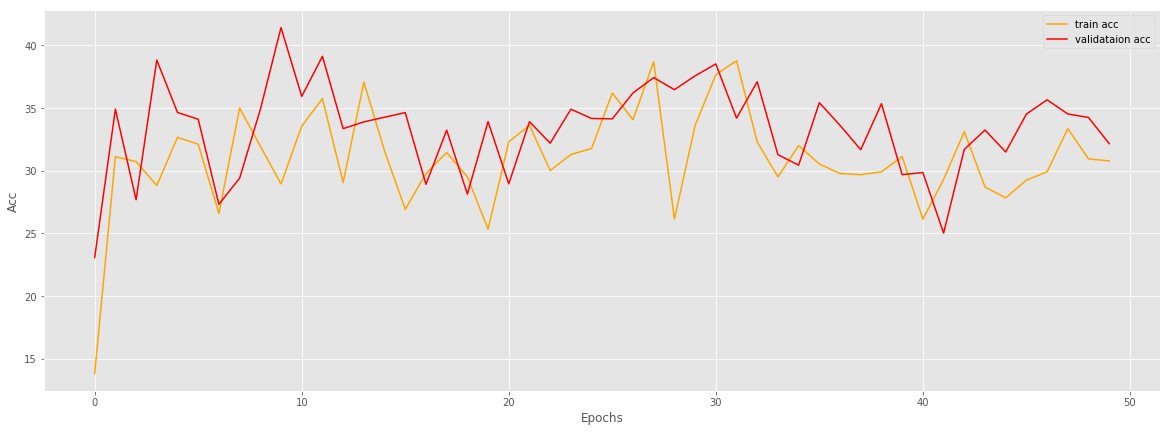

Max tr acc =  38.776666666666664
Max va acc =  41.42


In [25]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

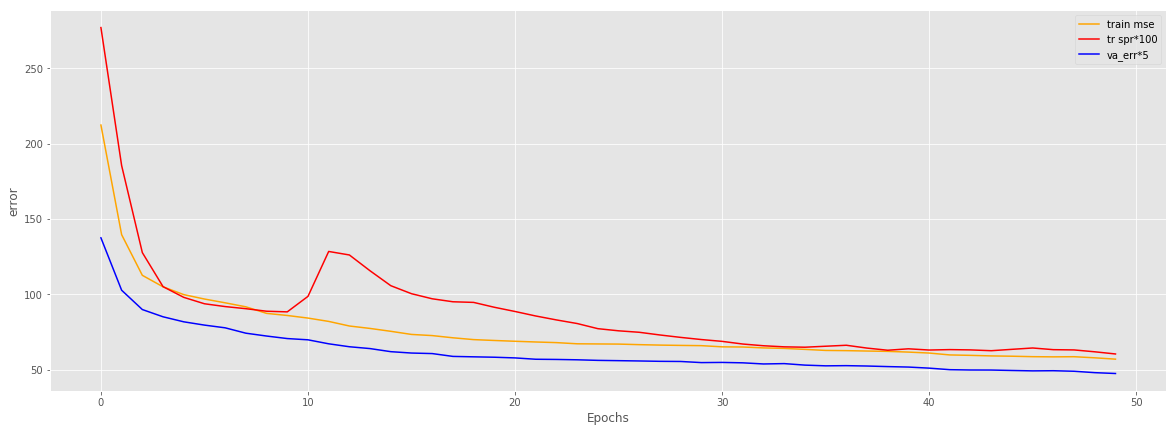

In [26]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 100*result_df_tr_all.values[:,4].squeeze()
va_err = 5*result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr*100')
plt.plot(va_err, color='blue', label='va_err*5')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()